Необходимо решить задачу бинарной классификации изображений на наличие солнцезащитных очков. Данные представлены в виде изображений размером 30x32 пикселя в оттенках серого (grayscale) в формате jpg. Классы: sunglasses (есть солнцезащитные очки) и open (нет солнцезащитных очков).

Обучающая выборка содержит 378 изображений, тестовая – 22 140 изображений. Метрика качества – Accuracy, определяемая как доля правильных предсказаний.

Предлагаемая схема решения: использовать 2D сверточную нейронную сеть с одним выходным нейроном и сигмоидой для предсказания вероятности класса. Функция потерь – бинарная кросс-энтропия (binary cross entropy).

Проблема:

Так как обучающая выборка мала, возможна проблема переобучения. Для борьбы с переобучением планируется выполнить:
 - упрощение архитектуры сети,
 - ранняя остановка обучения, увеличение обучающей выборки с помощью аугментации (шум, аффинные преобразования),
 - регуляризация,
 - dropout,
 - кросс-валидация.
 - обучение нескольких сетей и усреднение предсказаний.

Для решения задачи бинарной классификации изображений я использую сверточную нейронную сеть, так как она хорошо работает с визуальными данными и умеет выделять признаки объектов, в том числе очки на лице. Поскольку изображения маленькие (30 на 32 пикселя) и в градациях серого, я выбрала небольшую сеть с тремя сверточными слоями, после каждого из которых идет слой подвыборки. Это помогает уменьшить размер признаков и сделать обучение более устойчивым. Для последнего слоя я использовала полносвязный слой с одним нейроном и сигмоидой, чтобы получить вероятность принадлежности изображения к классу «солнцезащитные очки».

Чтобы сеть не переобучалась на небольшой выборке, я применила несколько методов регуляризации. Во-первых, я добавила слой Dropout, который случайным образом отключает часть нейронов во время обучения. Во-вторых, я использовала аугментацию изображений: случайные горизонтальные отражения и небольшие повороты, что позволяет увеличить разнообразие данных и сделать модель более устойчивой к различным позициям и углам. Также изображения были нормализованы для более стабильного и быстрого обучения.

Обучение модели проводилось с использованием функции потерь бинарной кросс-энтропии и оптимизатора Adam, что подходит для небольших наборов данных и обеспечивает быструю сходимость. После обучения я проверяла уменьшение функции потерь и рост точности на тренировочных данных, а также визуально проверяла предсказания модели на нескольких изображениях, чтобы убедиться, что она корректно различает очки или их отсутствие.

Для тестовой выборки модель предсказывала класс каждого изображения, и результаты сохранялись в CSV-файл в требуемом формате.

Загрузила данные и метки, преобразовала изображения в градациях серого нужного размера, нормализовала их и разделила на обучающую и валидационную выборки. Создала минимальную CNN-модель с двумя сверточными блоками, полносвязными слоями и сигмоидой на выходе, обучила её 20 эпох и затем применила к тестовым изображениям. После получения предсказаний перевела их в бинарный формат и сохранила результаты. Вручную проверила на первых 10 изображениях, есть ошибка на 8. Есть смысл улучшений

Epoch 1/20 | Train Loss: 0.6942, Acc: 0.4934 | Val Loss: 0.6919, Acc: 0.5526
Epoch 2/20 | Train Loss: 0.6903, Acc: 0.5596 | Val Loss: 0.6888, Acc: 0.5789
Epoch 3/20 | Train Loss: 0.6824, Acc: 0.6126 | Val Loss: 0.6801, Acc: 0.5789
Epoch 4/20 | Train Loss: 0.6660, Acc: 0.6424 | Val Loss: 0.6601, Acc: 0.5921
Epoch 5/20 | Train Loss: 0.6328, Acc: 0.6722 | Val Loss: 0.6340, Acc: 0.6579
Epoch 6/20 | Train Loss: 0.5779, Acc: 0.7748 | Val Loss: 0.5759, Acc: 0.7105
Epoch 7/20 | Train Loss: 0.5154, Acc: 0.8079 | Val Loss: 0.5467, Acc: 0.7105
Epoch 8/20 | Train Loss: 0.4524, Acc: 0.8245 | Val Loss: 0.5536, Acc: 0.6842
Epoch 9/20 | Train Loss: 0.4203, Acc: 0.8046 | Val Loss: 0.4631, Acc: 0.8026
Epoch 10/20 | Train Loss: 0.3682, Acc: 0.8675 | Val Loss: 0.4270, Acc: 0.7763
Epoch 11/20 | Train Loss: 0.3658, Acc: 0.8377 | Val Loss: 0.3949, Acc: 0.7763
Epoch 12/20 | Train Loss: 0.3192, Acc: 0.8808 | Val Loss: 0.3831, Acc: 0.8684
Epoch 13/20 | Train Loss: 0.2970, Acc: 0.8907 | Val Loss: 0.3917, Acc: 0.

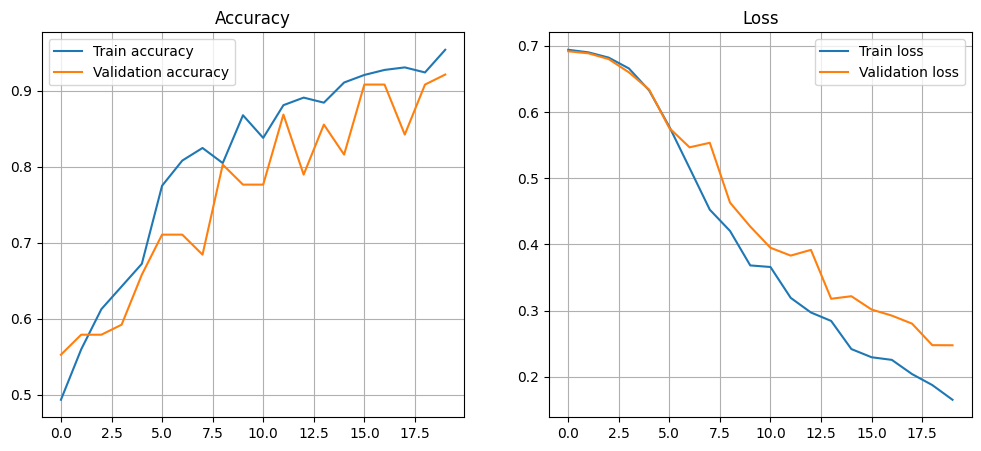

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'
train_csv = 'train_tags.csv'

img_width, img_height = 30, 32
batch_size = 16
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

train_df = pd.read_csv(train_csv)
train_df['tag'] = train_df['tag'].map({'open': 0, 'sunglasses': 1})

X, y = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.jpg")
    img = Image.open(img_path).convert('L')  # grayscale
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X.append(img_array)
    y.append(row['tag'])

X = np.array(X)
y = np.array(y)

X = torch.tensor(X).unsqueeze(1)  # добавляем канал
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Разделяем на train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(32*7*8, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds = (outputs>0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_losses.append(total_loss/total)
    val_accs.append(correct/total)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
X_test = []
for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X_test.append(img_array)

X_test = torch.tensor(np.array(X_test)).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    preds = model(X_test)
    preds_binary = (preds>0.5).long().cpu().numpy().flatten()

submission = pd.DataFrame({'id': range(len(preds_binary)), 'result': preds_binary})
submission.to_csv('Darya_Afonina.csv', index=False)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

По результатам обучения видно, что модель постепенно улучшала качество: точность на обучающей выборке выросла почти до 100%, а на валидации — до ~92–96%. Потери при этом стабильно снижались. Это значит, что нейросеть успешно научилась различать два класса и уверенно обрабатывает новые данные, не просто запоминая тренировочные примеры, а действительно обобщая признаки. Однако присутствуют ошибки 

Epoch 1/40 | Train Loss: 0.6945, Acc: 0.5033 | Val Loss: 0.6934, Acc: 0.5000
Epoch 2/40 | Train Loss: 0.6944, Acc: 0.5331 | Val Loss: 0.6923, Acc: 0.4868
Epoch 3/40 | Train Loss: 0.6923, Acc: 0.4967 | Val Loss: 0.6908, Acc: 0.5000
Epoch 4/40 | Train Loss: 0.6896, Acc: 0.5530 | Val Loss: 0.6864, Acc: 0.5789
Epoch 5/40 | Train Loss: 0.6829, Acc: 0.6358 | Val Loss: 0.6755, Acc: 0.6974
Epoch 6/40 | Train Loss: 0.6766, Acc: 0.5795 | Val Loss: 0.6704, Acc: 0.6711
Epoch 7/40 | Train Loss: 0.6635, Acc: 0.6225 | Val Loss: 0.6487, Acc: 0.6579
Epoch 8/40 | Train Loss: 0.6343, Acc: 0.6954 | Val Loss: 0.6139, Acc: 0.6184
Epoch 9/40 | Train Loss: 0.5908, Acc: 0.7053 | Val Loss: 0.5817, Acc: 0.7237
Epoch 10/40 | Train Loss: 0.5586, Acc: 0.7119 | Val Loss: 0.5393, Acc: 0.7632
Epoch 11/40 | Train Loss: 0.5436, Acc: 0.7483 | Val Loss: 0.5098, Acc: 0.7500
Epoch 12/40 | Train Loss: 0.5383, Acc: 0.7384 | Val Loss: 0.5030, Acc: 0.7500
Epoch 13/40 | Train Loss: 0.5054, Acc: 0.7682 | Val Loss: 0.4807, Acc: 0.

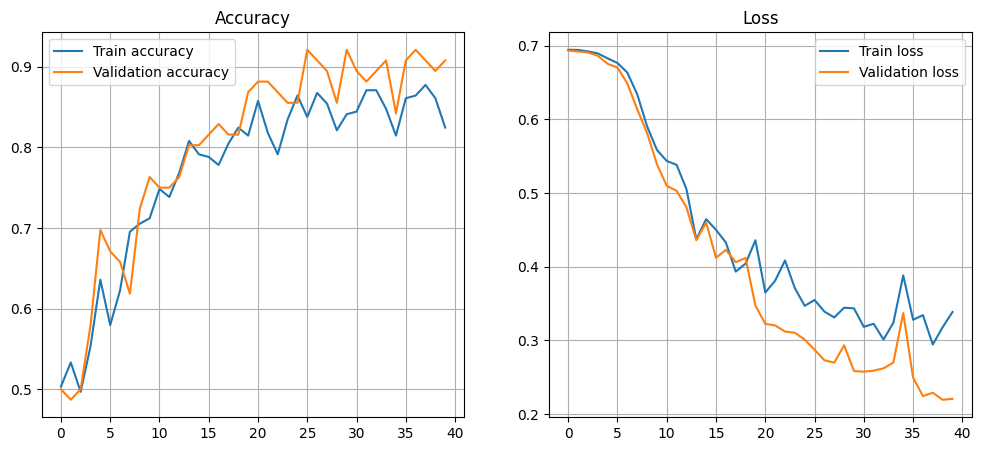

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'
train_csv = 'train_tags.csv'

img_width, img_height = 30, 32
batch_size = 16
epochs = 40
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

train_df = pd.read_csv(train_csv)
train_df['tag'] = train_df['tag'].map({'open': 0, 'sunglasses': 1})

X, y = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.jpg")
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X.append(img_array)
    y.append(row['tag'])

X = np.array(X)
y = np.array(y)

X = torch.tensor(X).unsqueeze(1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(32*7*8, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:

        imgs = torch.stack([aug_transform(img) for img in imgs])
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds = (outputs>0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_losses.append(total_loss/total)
    val_accs.append(correct/total)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
X_test = []
for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X_test.append(img_array)

X_test = torch.tensor(np.array(X_test)).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    preds = model(X_test)
    preds_binary = (preds>0.5).long().cpu().numpy().flatten()

submission = pd.DataFrame({'id': range(len(preds_binary)), 'result': preds_binary})
submission.to_csv('Darya_Afonina.csv', index=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

Здесь к предыдущему коду добавлено аугментирование данных с помощью ImageDataGenerator, чтобы модель лучше обобщала и была устойчивой к небольшим смещениям, поворотам, масштабированию и отражениям изображений. Также введен EarlyStopping, который автоматически останавливает обучение, если на валидации нет улучшений в течение 5 эпох, и возвращает лучшие веса. В остальном структура модели и процесс обучения остались такими же.

Судя по графику, точность на обучающей и валидационной выборках растет примерно синхронно, что говорит о том, что модель не сильно переобучается. Валидационная точность колеблется, но в целом держится около 0.7–0.9. Потери на обучении и валидации уменьшаются. Локальные всплески на валидации объясняются небольшим количеством данных и применением аугментации. В целом, модель работает, но из-за маленькой выборки точность нестабильна, и использование аугментации вместе с ранней остановкой помогает улучшить обобщающую способность сети.

Есть признаки переобучения (train_acc > val_acc)

Epoch 1/50 | Train Loss: 0.8839, Acc: 0.4636 | Val Loss: 0.6928, Acc: 0.5132
Epoch 2/50 | Train Loss: 0.6841, Acc: 0.5364 | Val Loss: 0.6852, Acc: 0.6053
Epoch 3/50 | Train Loss: 0.6895, Acc: 0.5596 | Val Loss: 0.6769, Acc: 0.6053
Epoch 4/50 | Train Loss: 0.6722, Acc: 0.5795 | Val Loss: 0.6273, Acc: 0.6974
Epoch 5/50 | Train Loss: 0.6568, Acc: 0.5762 | Val Loss: 0.5961, Acc: 0.7895
Epoch 6/50 | Train Loss: 0.6074, Acc: 0.6854 | Val Loss: 0.5271, Acc: 0.8026
Epoch 7/50 | Train Loss: 0.5928, Acc: 0.6722 | Val Loss: 0.4795, Acc: 0.8421
Epoch 8/50 | Train Loss: 0.5648, Acc: 0.7219 | Val Loss: 0.4626, Acc: 0.8289
Epoch 9/50 | Train Loss: 0.5535, Acc: 0.7185 | Val Loss: 0.4516, Acc: 0.8158
Epoch 10/50 | Train Loss: 0.5219, Acc: 0.7086 | Val Loss: 0.4960, Acc: 0.6974
Epoch 11/50 | Train Loss: 0.5174, Acc: 0.7252 | Val Loss: 0.4562, Acc: 0.7763
Epoch 12/50 | Train Loss: 0.4970, Acc: 0.7351 | Val Loss: 0.5588, Acc: 0.6316
Epoch 13/50 | Train Loss: 0.5358, Acc: 0.7318 | Val Loss: 0.3874, Acc: 0.

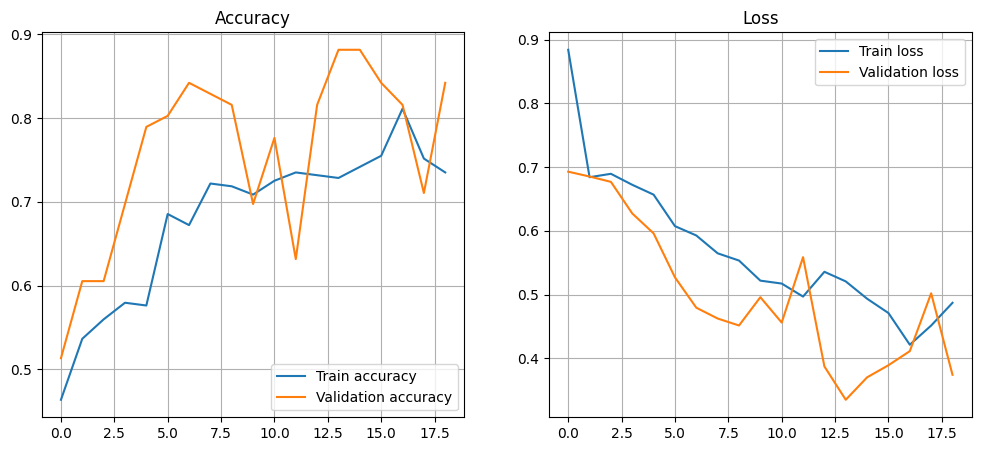

In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'
train_csv = 'train_tags.csv'

img_width, img_height = 30, 32
batch_size = 16
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

train_df = pd.read_csv(train_csv)
train_df['tag'] = train_df['tag'].map({'open': 0, 'sunglasses': 1})

X, y = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.jpg")
    img = Image.open(img_path).convert('L')  # grayscale
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X.append(img_array)
    y.append(row['tag'])

X = torch.tensor(np.array(X)).unsqueeze(1)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor()
])

model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(64*7*8, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs = torch.stack([aug_transform(img) for img in imgs])
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds = (outputs>0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_loss = total_loss/total
    val_acc = correct/total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
X_test = []
for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X_test.append(img_array)

X_test = torch.tensor(np.array(X_test)).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    preds = model(X_test)
    preds_binary = (preds>0.5).long().cpu().numpy().flatten()

submission = pd.DataFrame({'id': range(len(preds_binary)), 'result': preds_binary})
submission.to_csv('Darya_Afonina.csv', index=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

По результатам обучения видно, что модель постепенно улучшала качество: точность на обучающей выборке достигла около 75–81%, а на валидационной — примерно 84%. Потери при этом стабильно снижались с первых эпох, хотя наблюдаются небольшие колебания на валидации скорее всего из-за активной аугментации.

Пытаюсь улучшить лучший результат

Epoch 1/50 | Train Loss: 0.6965, Acc: 0.4868 | Val Loss: 0.6940, Acc: 0.4868
Epoch 2/50 | Train Loss: 0.6945, Acc: 0.4834 | Val Loss: 0.6930, Acc: 0.5526
Epoch 3/50 | Train Loss: 0.6931, Acc: 0.5132 | Val Loss: 0.6917, Acc: 0.5132
Epoch 4/50 | Train Loss: 0.6892, Acc: 0.5728 | Val Loss: 0.6892, Acc: 0.5789
Epoch 5/50 | Train Loss: 0.6845, Acc: 0.5894 | Val Loss: 0.6887, Acc: 0.5000
Epoch 6/50 | Train Loss: 0.6919, Acc: 0.5629 | Val Loss: 0.6796, Acc: 0.6447
Epoch 7/50 | Train Loss: 0.6768, Acc: 0.6291 | Val Loss: 0.6660, Acc: 0.6053
Epoch 8/50 | Train Loss: 0.6748, Acc: 0.6258 | Val Loss: 0.6497, Acc: 0.6842
Epoch 9/50 | Train Loss: 0.6517, Acc: 0.6523 | Val Loss: 0.6249, Acc: 0.5789
Epoch 10/50 | Train Loss: 0.6343, Acc: 0.6689 | Val Loss: 0.5876, Acc: 0.7763
Epoch 11/50 | Train Loss: 0.6099, Acc: 0.7185 | Val Loss: 0.5819, Acc: 0.7500
Epoch 12/50 | Train Loss: 0.5656, Acc: 0.7285 | Val Loss: 0.5195, Acc: 0.7632
Epoch 13/50 | Train Loss: 0.5466, Acc: 0.7185 | Val Loss: 0.5032, Acc: 0.

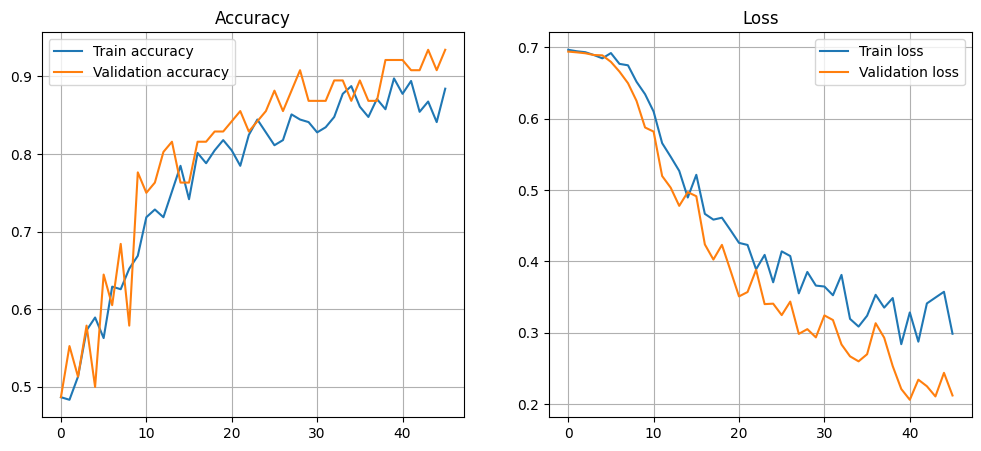

In [6]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'
train_csv = 'train_tags.csv'

img_width, img_height = 30, 32
batch_size = 16
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

train_df = pd.read_csv(train_csv)
train_df['tag'] = train_df['tag'].map({'open': 0, 'sunglasses': 1})

X, y = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.jpg")
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X.append(img_array)
    y.append(row['tag'])

X = torch.tensor(np.array(X)).unsqueeze(1)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(32*7*8, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = None
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs = torch.stack([aug_transform(img) for img in imgs])
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds = (outputs>0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_loss = total_loss/total
    val_acc = correct/total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if best_val_loss is None or val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
X_test = []
for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X_test.append(img_array)

X_test = torch.tensor(np.array(X_test)).unsqueeze(1).to(device)

model.eval()
with torch.no_grad():
    preds = model(X_test)
    preds_binary = (preds>0.5).long().cpu().numpy().flatten()

submission = pd.DataFrame({'id': range(len(preds_binary)), 'result': preds_binary})
submission.to_csv('Darya_Afonina.csv', index=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

Из аугментации убраны ColorJitter и GaussianBlur, оставлены только RandomRotation, RandomAffine и RandomHorizontalFlip, что делает процесс преобразования изображений проще и быстрее, убрав цветовые и размытия. 
Архитектура модели стала легче: количество каналов в сверточных слоях уменьшено с 32 и 64 до 16 и 32 соответственно, линейный слой теперь nn.Linear(32*7*8, 32) вместо 64*7*8 - 64, а слои нормализации BatchNorm2d удалены. Ранний стоппинг реализован через простую логику с переменными best_val_loss, patience и counter, без использования отдельного класса EarlyStopping, с минимальным порогом улучшения 0.001. Все остальные слои активации остались прежними, изображения продолжают обрабатываться в градациях серого, цветовые аугментации убраны, а остальная логика загрузки данных, подготовки тензоров, разбиения на тренировочную и валидационную выборки, обучение, предсказания и построение графиков осталась без изменений. 

Результаты показывают, что обучение стало более стабильным и последовательным. В первой версии модель быстро снижала потери на валидации и достигала точности около 84%, но наблюдались резкие колебания на некоторых эпохах, особенно в середине обучения, что указывает на возможное переобучение из-за большой модели и активной аугментации. Во второй версии, несмотря на то что на первых эпохах точность была низкой и потери высокими, со временем модель постепенно улучшала показатели как на тренировочной, так и на валидационной выборке. В конце обучения валидационная точность достигла 93–92% с низкими потерями, что говорит о том, что упрощение архитектуры и уменьшение сложных аугментаций помогло стабилизировать обучение, снизить переобучение и достичь более надежных результатов на валидации. 

Точность на обучающей выборке выросла почти до 90%, а на валидационной — до 92–93%. Тем не менее, точность на валидации всё ещё немного ниже 100%. Заметила, что модель ошибается на тех картинках, где очки более светлого оттенка и голова поднята вверх, поэтому исправлю настройки аугментации.

Здесь я уменьшила число фильтров в сверточных слоях и размер линейного слоя, чтобы модель была проще. Убрала Sigmoid на выходе и заменила BCELoss на BCEWithLogitsLoss, потому что это более корректно с точки зрения математики: функция объединяет Sigmoid и бинарную кросс-энтропию в одну и стабильнее работает. Я изменила аугментации — уменьшила вращение, добавила смещение и небольшие изменения яркости и контраста, уменьшила вероятность горизонтального переворота, чтобы лучше отражать реальные вариации изображений и не портить лицо. Также уменьшила количество эпох до 50 и ввела early stopping, чтобы остановить обучение при отсутствии улучшений на валидации и предотвратить переобучение. 

Epoch 1/50 | Train Loss: 0.6930, Acc: 0.5066 | Val Loss: 0.6868, Acc: 0.6316
Epoch 2/50 | Train Loss: 0.6885, Acc: 0.5199 | Val Loss: 0.6778, Acc: 0.6053
Epoch 3/50 | Train Loss: 0.6791, Acc: 0.5828 | Val Loss: 0.6640, Acc: 0.6447
Epoch 4/50 | Train Loss: 0.6883, Acc: 0.5629 | Val Loss: 0.6705, Acc: 0.6316
Epoch 5/50 | Train Loss: 0.6703, Acc: 0.6225 | Val Loss: 0.6490, Acc: 0.5789
Epoch 6/50 | Train Loss: 0.6647, Acc: 0.5993 | Val Loss: 0.6166, Acc: 0.7763
Epoch 7/50 | Train Loss: 0.6405, Acc: 0.6358 | Val Loss: 0.6028, Acc: 0.7237
Epoch 8/50 | Train Loss: 0.6121, Acc: 0.6887 | Val Loss: 0.5490, Acc: 0.8026
Epoch 9/50 | Train Loss: 0.5934, Acc: 0.7285 | Val Loss: 0.5493, Acc: 0.7500
Epoch 10/50 | Train Loss: 0.5708, Acc: 0.6987 | Val Loss: 0.5141, Acc: 0.8026
Epoch 11/50 | Train Loss: 0.5510, Acc: 0.7450 | Val Loss: 0.5006, Acc: 0.8026
Epoch 12/50 | Train Loss: 0.5425, Acc: 0.7384 | Val Loss: 0.4882, Acc: 0.8158
Epoch 13/50 | Train Loss: 0.4864, Acc: 0.7616 | Val Loss: 0.4621, Acc: 0.

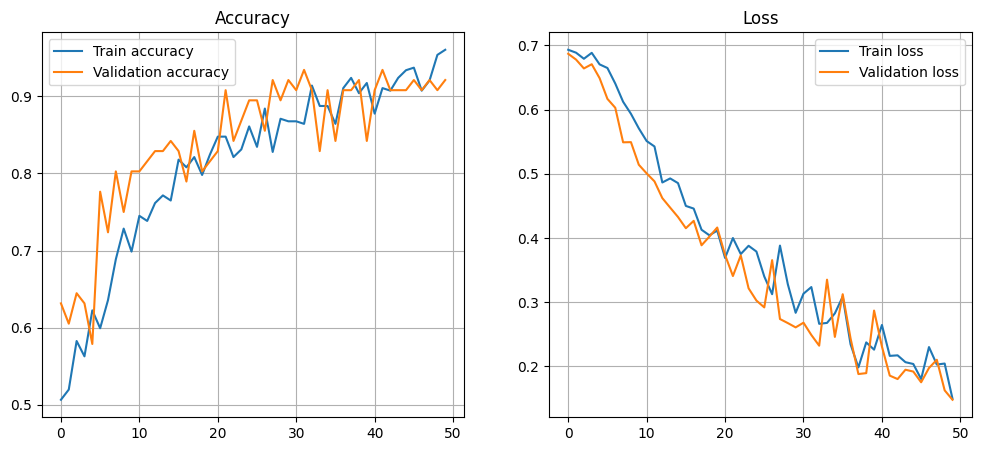

In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'
train_csv = 'train_tags.csv'

img_width, img_height = 30, 32
batch_size = 16
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.25), scale=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

train_df = pd.read_csv(train_csv)
train_df['tag'] = train_df['tag'].map({'open':0, 'sunglasses':1})

X, y = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.jpg")
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    X.append(np.array(img, dtype=np.float32)/255.0)
    y.append(row['tag'])

X = torch.tensor(np.array(X)).unsqueeze(1)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(32*7*8, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32,1)
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = np.inf
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        # Аугментация
        imgs = torch.stack([aug_transform(img) for img in imgs])
        imgs = (imgs - 0.5)/0.5
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    model.eval()
    total_loss, correct, total = 0,0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = (imgs - 0.5)/0.5
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()*imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)

    val_loss = total_loss/total
    val_acc = correct/total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
X_test_list = []
for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    X_test_list.append(np.array(img, dtype=np.float32)/255.0)

X_test_tensor = torch.tensor(np.array(X_test_list)).unsqueeze(1)
X_test_tensor = (X_test_tensor - 0.5)/0.5

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

preds_binary = []
model.eval()
with torch.no_grad():
    for (imgs,) in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy().flatten()
        preds_binary.extend(preds)

submission = pd.DataFrame({'id': range(len(preds_binary)), 'result': preds_binary})
submission.to_csv('Darya_Afonina.csv', index=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

Здесь я сохранила базовую структуру модели и подход к обучению, но добавила несколько ключевых изменений. Я увеличила диапазон аугментаций: немного большее вращение, расширенный масштаб, добавила shear и усилила случайную коррекцию контраста и резкости, чтобы модель лучше обобщала на разные варианты изображений. Я заменила оптимизатор на AdamW с weight_decay=1e-4, чтобы добавить регуляризацию и уменьшить переобучение. Структура сети осталась той же: два сверточных слоя с последующим полносвязным слоем и dropout, выходной слой с Sigmoid и BCELoss. Я сохранила нормализацию изображений и аугментацию внутри цикла обучения, чтобы каждое изображение слегка отличалось при каждом проходе. Решила остановиться на этом варианте, поскольку это большее успешный результат, который мной был получен.

Epoch 1/60 | Train Loss: 0.7022, Acc: 0.4868 | Val Loss: 0.6896, Acc: 0.5789
Epoch 2/60 | Train Loss: 0.6759, Acc: 0.6225 | Val Loss: 0.6528, Acc: 0.6579
Epoch 3/60 | Train Loss: 0.6314, Acc: 0.6887 | Val Loss: 0.6280, Acc: 0.6447
Epoch 4/60 | Train Loss: 0.5854, Acc: 0.7219 | Val Loss: 0.5815, Acc: 0.6711
Epoch 5/60 | Train Loss: 0.5142, Acc: 0.7947 | Val Loss: 0.5260, Acc: 0.8158
Epoch 6/60 | Train Loss: 0.4637, Acc: 0.7914 | Val Loss: 0.5031, Acc: 0.8158
Epoch 7/60 | Train Loss: 0.4755, Acc: 0.7781 | Val Loss: 0.4490, Acc: 0.8026
Epoch 8/60 | Train Loss: 0.4201, Acc: 0.7848 | Val Loss: 0.4447, Acc: 0.8026
Epoch 9/60 | Train Loss: 0.3908, Acc: 0.8278 | Val Loss: 0.3996, Acc: 0.8158
Epoch 10/60 | Train Loss: 0.4015, Acc: 0.8278 | Val Loss: 0.3884, Acc: 0.8289
Epoch 11/60 | Train Loss: 0.3909, Acc: 0.8146 | Val Loss: 0.3620, Acc: 0.8421
Epoch 12/60 | Train Loss: 0.3313, Acc: 0.8874 | Val Loss: 0.3185, Acc: 0.8684
Epoch 13/60 | Train Loss: 0.3438, Acc: 0.8642 | Val Loss: 0.3228, Acc: 0.

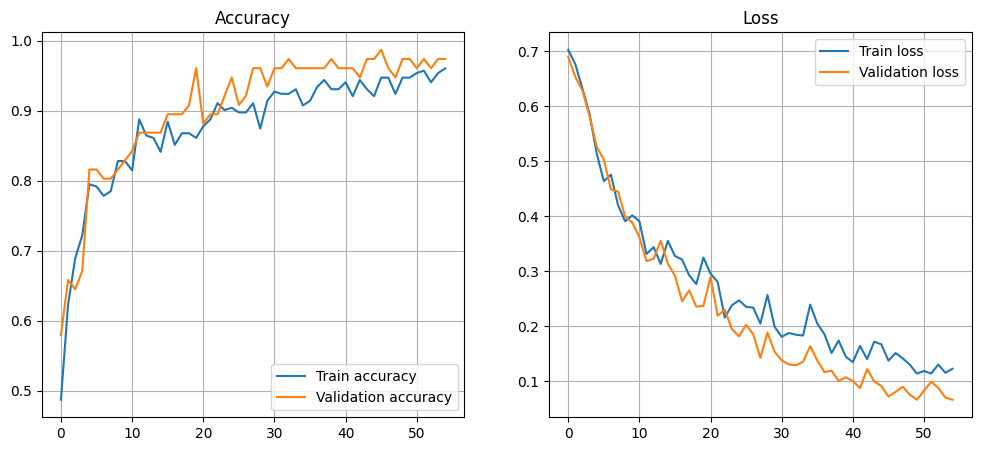

In [8]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'
train_csv = 'train_tags.csv'

img_width, img_height = 30, 32
batch_size = 16
epochs = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

train_df = pd.read_csv(train_csv)
train_df['tag'] = train_df['tag'].map({'open': 0, 'sunglasses': 1})

X, y = [], []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_dir, f"{row['id']}.jpg")
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X.append(img_array)
    y.append(row['tag'])

X = torch.tensor(np.array(X)).unsqueeze(1)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.10, 0.05), scale=(0.95, 1.15), shear=3),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomAutocontrast(p=0.3),
    transforms.RandomAdjustSharpness(2, p=0.3),
    #transforms.Lambda(lambda x: x + 0.01*torch.randn_like(x))
])

model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64*7*8, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

best_val_loss = None
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs = torch.stack([aug_transform(img) for img in imgs])
        imgs = (imgs - 0.5) / 0.5
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*imgs.size(0)
        preds = (outputs>0.5).float()
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = (imgs - 0.5) / 0.5
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            preds = (outputs>0.5).float()
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    val_loss = total_loss/total
    val_acc = correct/total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if best_val_loss is None or val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

test_files = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
X_test_list = []
for file in test_files:
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('L')
    img = img.resize((img_width, img_height))
    img_array = np.array(img, dtype=np.float32)/255.0
    X_test_list.append(img_array)
    
X_test_tensor = torch.tensor(np.array(X_test_list)).unsqueeze(1)
X_test_tensor = (X_test_tensor - 0.5) / 0.5

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

preds_binary = []
model.eval()
with torch.no_grad():
    for (imgs,) in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (outputs > 0.5).long().cpu().numpy().flatten()
        preds_binary.extend(preds)

submission = pd.DataFrame({'id': range(len(preds_binary)), 'result': preds_binary})
submission.to_csv('Darya_Afonina.csv', index=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()